#Install dependencies


In [ ]:
import torch

if torch.cuda.is_available():    
   
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 14.8MB/s 
     |████████████████████████████████| 2.9MB 52.6MB/s 
     |████████████████████████████████| 890kB 50.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d34a617854e95d6333e2c6d703bb51e1e9d72772f9c4aca5d4153ff654e5f4f8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
!ls /gdrive/MyDrive/twitter_sentiment

french_tweets.csv     twitter_sentiment_bert_full.csv
french_tweets_me.csv  twitter_sentiment_bert_med.csv
model_save


#Load Dataset

In [ ]:
#loading the dataset
import pandas as pd

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

#df=pd.read_csv('./twitter_sentiment_bert.csv',encoding="ISO-8859-1",names=["target", "ids", "date", "flag", "user", "text"])
df1=pd.read_csv('/gdrive/MyDrive/twitter_sentiment/french_tweets_me.csv')
df1

,Unnamed: 0,label,text
0,613362,0,Whoops! Pardon
1,613363,0,"Je l'ai vu, mais je ne les ai jamais vus dans les magasins d'alimentation ici, je vais devoir regarder mieux la prochaine fois que je vais faire du shopping. Merci!"
2,613364,0,Dernier jour ko ng mobwars insider huhuhu
3,613365,0,Je ne peux vraiment pas dormir
4,613366,0,Je suis envahie par les moustiques géants. Quelle soirée de houle
...,...,...,...
299995,913357,1,C'est sérieusement.
299996,913358,1,"Nous sommes allés aux fantômes des petites amies après que c'était bon et que dani a apporté son petit ami et des amis de somme, c'était vraiment amusant"
299997,913359,1,Brandon !!! Où es-tu? & Lt; ~ kc ~ & gt;
299998,913360,1,- Qu'est-ce que c'est? J'ai besoin de plus d'informations!


In [ ]:
df2=pd.read_csv('/gdrive/MyDrive/twitter_sentiment/twitter_sentiment_bert_med.csv')
df2.rename(columns={'target':'label'},inplace=True)
df2

,Unnamed: 0,label,text
0,700000,0,People are tweeting advice on how to combat tear gas in Iran. #iranelection
1,700001,0,"can't go 2 the anberlin show 2nite, tickets sold out before doc gave approval."
2,700002,0,Woke up with lots of wisdom teeth drama..Gotta get these things removed soon.
3,700003,0,@tom_teel Not yet dude... Gonna have to buy a new one
4,700004,0,everytime i fall asleep my dreams are haunted
...,...,...,...
199995,899995,1,"@jvdouglas haha, no, the remark on maternity leave fired me up a little"
199996,899996,1,@altitis and to you!
199997,899997,1,Okie doke!! Time for me to escape for the North while Massa's back is turned. Be on when I get home folks
199998,899998,1,"finished the lessons, hooray!"


In [ ]:
df=df1.append(df2, ignore_index=True)
df

,Unnamed: 0,label,text
0,613362,0,Whoops! Pardon
1,613363,0,"Je l'ai vu, mais je ne les ai jamais vus dans les magasins d'alimentation ici, je vais devoir regarder mieux la prochaine fois que je vais faire du shopping. Merci!"
2,613364,0,Dernier jour ko ng mobwars insider huhuhu
3,613365,0,Je ne peux vraiment pas dormir
4,613366,0,Je suis envahie par les moustiques géants. Quelle soirée de houle
...,...,...,...
499995,899995,1,"@jvdouglas haha, no, the remark on maternity leave fired me up a little"
499996,899996,1,@altitis and to you!
499997,899997,1,Okie doke!! Time for me to escape for the North while Massa's back is turned. Be on when I get home folks
499998,899998,1,"finished the lessons, hooray!"


In [ ]:
df.label.value_counts()

0    258242
1    241758
Name: label, dtype: int64

In [ ]:
sentences = df.text.values
labels= df.label.values

In [ ]:
'''y = np.bincount(labels)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii]))'''

'y = np.bincount(labels)\nii = np.nonzero(y)[0]\nlist(zip(ii,y[ii]))'

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 13.6MB/s 


#Data preprocessing

In [ ]:
from transformers import XLMRobertaTokenizer

# Load the XLMRobertaTokenizer tokenizer.
print('Loading XLMRobertaTokenizer ...')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large', do_lower_case=True)

Loading XLMRobertaTokenizer ...


In [ ]:
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Whoops! Pardon
Tokenized:  ['▁Who', 'ops', '!', '▁Par', 'don']
Token IDs:  [40469, 68818, 38, 2392, 4445]


In [ ]:
#to get max length 
#train['comment_text'].apply(lambda x:len(str(x).split())).max()
max_len=df['text'].apply(lambda x:len(tokenizer.encode(x,add_special_tokens=True))).max()
print('Max sentence tokens: ', max_len)

Max sentence tokens:  267


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


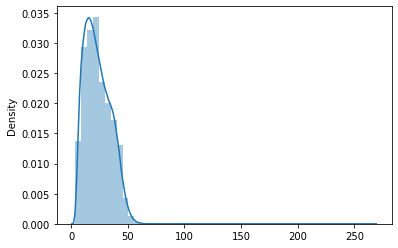

In [ ]:
import seaborn as sns

sns.distplot(length)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',   
                        truncation=True
                   )
        
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Whoops! Pardon
Token IDs: tensor([    0, 40469, 68818,    38,  2392,  4445,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


In [ ]:
#labels=[1 if i==4 else 0 for i in labels]

In [ ]:
#l=pd.DataFrame(labels)
#l[0].value_counts()

In [ ]:
labels = torch.tensor(labels,dtype=torch.long)
labels[0]

tensor(0)

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#print('{:>5,} training samples'.format(train_size))
#print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

#Building Model

In [ ]:
from transformers import XLMRobertaForSequenceClassification, AdamW, BertConfig

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels = 2, 
    output_attentions = False,
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
for batch in train_dataloader:
  print(batch[0],batch[2])
  break

tensor([[     0,   1374,    177,  ...,      1,      1,      1],
        [     0,   1374, 128897,  ...,      1,      1,      1],
        [     0,    845,   5189,  ...,      1,      1,      1],
        ...,
        [     0,   1468,  31251,  ...,      1,      1,      1],
        [     0,   1374,  72253,  ...,      1,      1,      1],
        [     0,    541,    248,  ...,      1,      1,      1]]) tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1])


#Training Model

In [ ]:
CUDA_LAUNCH_BLOCKING="1"
import random
import numpy as np

seed_val = 200

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
  

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss=outputs[0]
        logits=outputs[1]
        

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                    labels=b_labels)
            loss=outputs[0]
            logits=outputs[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  14,063.    Elapsed: 0:00:16.
  Batch    80  of  14,063.    Elapsed: 0:00:33.
  Batch   120  of  14,063.    Elapsed: 0:00:50.
  Batch   160  of  14,063.    Elapsed: 0:01:07.
  Batch   200  of  14,063.    Elapsed: 0:01:24.
  Batch   240  of  14,063.    Elapsed: 0:01:41.
  Batch   280  of  14,063.    Elapsed: 0:01:58.
  Batch   320  of  14,063.    Elapsed: 0:02:16.
  Batch   360  of  14,063.    Elapsed: 0:02:34.
  Batch   400  of  14,063.    Elapsed: 0:02:52.
  Batch   440  of  14,063.    Elapsed: 0:03:09.
  Batch   480  of  14,063.    Elapsed: 0:03:27.
  Batch   520  of  14,063.    Elapsed: 0:03:45.
  Batch   560  of  14,063.    Elapsed: 0:04:02.
  Batch   600  of  14,063.    Elapsed: 0:04:20.
  Batch   640  of  14,063.    Elapsed: 0:04:38.
  Batch   680  of  14,063.    Elapsed: 0:04:55.
  Batch   720  of  14,063.    Elapsed: 0:05:13.
  Batch   760  of  14,063.    Elapsed: 0:05:31.
  Batch   800  of  14,063.    Elapsed: 0:05:4

In [ ]:
import pandas as pd


pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')


df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.39,0.35,0.85,1:43:20,0:03:07
2,0.31,0.34,0.86,1:43:25,0:03:07
3,0.26,0.35,0.86,1:43:27,0:03:08


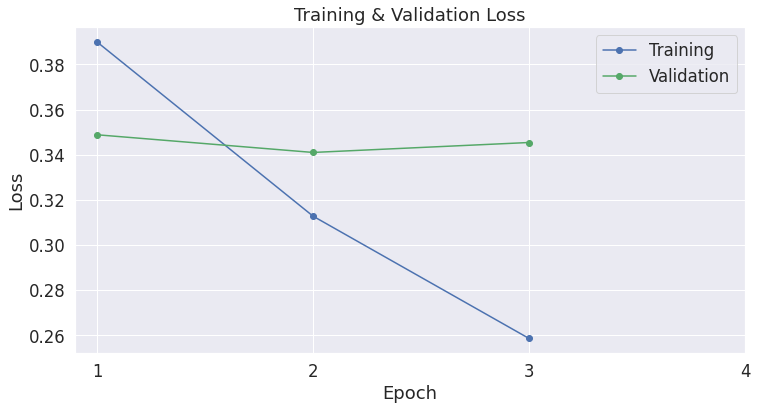

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
sent='I give it a fuck'
encoded=tokenizer.encode(sent,max_length=64,truncation=True,pad_to_max_length = True,
                        return_attention_mask = True,   
                        )

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 64,           
                        #pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',   
                        truncation=True
                   )

{'input_ids': tensor([[    0,    87,  8337,   442,    10, 40878,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
import numpy as np
def encode_reviews( reviews):
        token_ids = np.zeros(shape=(len(reviews), MAX_SEQ_LEN), dtype=np.int32)
        for i, review in enumerate(reviews):
            print(review)
            encoded = tokenizer.encode(review, max_length=MAX_SEQ_LEN, truncation=True)
            print(encoded)
            token_ids[i, 0:len(encoded)] = encoded
        attention_mask = (token_ids != 0).astype(np.int32)
        return {"input_ids": token_ids, "attention_mask": attention_mask} 

In [ ]:
encoded_output=encode_reviews(sent)
encoded_output

I
[0, 87, 2]
 
[0, 2]
g
[0, 706, 2]
i
[0, 17, 2]
v
[0, 81, 2]
e
[0, 28, 2]
 
[0, 2]
i
[0, 17, 2]
t
[0, 808, 2]
 
[0, 2]
a
[0, 10, 2]
 
[0, 2]
f
[0, 1238, 2]
u
[0, 75, 2]
c
[0, 501, 2]
k
[0, 472, 2]


{'attention_mask': array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]], dtype=int32),
 'input_ids': array([[  0,  87,   2, ...,   0,   0,   0],
        [  0,   2,   0, ...,   0,   0,   0],
        [  0, 706,   2, ...,   0,   0,   0],
        ...,
        [  0,  75,   2, ...,   0,   0,   0],
        [  0, 501,   2, ...,   0,   0,   0],
        [  0, 472,   2, ...,   0,   0,   0]], dtype=int32)}

In [ ]:
sent='tres bien et il est  heurex'
MAX_SEQ_LEN=64
def encode_func(sent):
  encode=tokenizer.encode_plus(sent, 
                               max_length=MAX_SEQ_LEN,
                               pad_to_max_length=True,truncation=True,
                               return_attention_mask=True,
                               return_tensors='pt')
  encode.to(device)
  return encode
encoded_output=encode_func(sent)
encoded_output

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': tensor([[     0,   5456,   1806,     82,    211,    437, 118166,    425,      2,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}

In [ ]:
# Put model in evaluation mode
model.eval()


result=model(input_ids=encoded_output['input_ids'],attention_mask=encoded_output['attention_mask'])
_,prediction=torch.max(result[0],dim=1)
output=prediction.item()
output

1

In [ ]:
#saving model
import os

output_dir = "/gdrive/MyDrive/twitter_sentiment/model_save"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



Saving model to /gdrive/MyDrive/twitter_sentiment/model_save


('/gdrive/MyDrive/twitter_sentiment/model_save/tokenizer_config.json',
 '/gdrive/MyDrive/twitter_sentiment/model_save/special_tokens_map.json',
 '/gdrive/MyDrive/twitter_sentiment/model_save/sentencepiece.bpe.model',
 '/gdrive/MyDrive/twitter_sentiment/model_save/added_tokens.json')

In [ ]:
'''# Mount Google Drive to this Notebook instance.
from google.colab import drive
    drive.mount('/content/drive') '''

In [ ]:
'''# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/BERT Fine-Tuning/"'''

In [ ]:
output_dir="/gdrive/MyDrive/twitter_sentiment/model_save"

# Load a trained model and vocabulary that you have fine-tuned
model = XLMRobertaForSequenceClassification.from_pretrained(output_dir)
tokenizer = XLMRobertaTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

In [ ]:
import torch
from torch import cuda
from transformers import XLMRobertaForSequenceClassification
from transformers import XLMRobertaTokenizer

class SentimentPredictor:
  def __init__(self,model_weight_path,max_length=64):
    self.device='cuda' if cuda.is_available() else 'cpu'
    self.tokenizer=XLMRobertaTokenizer.from_pretrained(model_weight_path)
    self.MAX_SEQ_LEN=max_length
    self.model=XLMRobertaForSequenceClassification.from_pretrained(model_weight_path)
    #self.model.to(self.device)

  def encode_reviews(self, reviews):
    encode=self.tokenizer.encode_plus(
                        reviews,                      
                        add_special_tokens = True,
                        max_length = self.MAX_SEQ_LEN,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',   
                        truncation=True
                    )
    #encode.to(self.device)
    return encode

  def predict(self, reviews):
    encoded_output=self.encode_reviews(reviews)
    result=self.model(input_ids=encoded_output['input_ids'],attention_mask=encoded_output['attention_mask'])
    _,prediction=torch.max(result[0],dim=1)
    output=prediction.item()
    sentiment='Positive' if output==1 else 'Negative'
    return sentiment


In [ ]:
output_dir="/gdrive/MyDrive/twitter_sentiment/model_save"

sentiment=SentimentPredictor(model_weight_path=output_dir)



In [ ]:
sentiment.predict('THis is very very good')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'Positive'